In [1]:
import os
import copy
import time
import random
import numpy as np

import itertools
import functools

import torch
import torch.nn as nn
import torch.optim as opt
import torch.nn.functional as F
import torch.utils.data as data

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from matplotlib import pyplot as plt

SEED = 241

In [2]:
def seed_everything(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)

  if torch.cuda.is_available(): 
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [3]:
class EMNISTDataset(data.Dataset):

  def __init__(self, train: bool = True, 
               max_seq_len: int = 1, 
               blank_label = 11,
               pad_label = 10,
               img_size: [int, int] = (28, 28)):
      self.dataset = datasets.EMNIST(root='./data', 
                                     split='mnist',
                                     train=train,
                                     download=True)
      self.max_seq_len = max_seq_len
      self.img_size = img_size

  def __getitem__(self, index):
    labels = []
   
    image_seq = np.zeros((self.img_size[0], self.img_size[1] * self.max_seq_len))
    seq_len = random.randint(self.max_seq_len // 2, self.max_seq_len)
    bias = abs(np.random.normal(loc=0, scale=5, size=(seq_len,)))
    
    for i in range(0, seq_len):
      index = random.randint(0, self.dataset.train_data.size(0) - 1)
      image, label = self.dataset[index]
      image = transforms.functional.rotate(image, angle=-90)
      image = transforms.functional.hflip(image)
      image = np.array(image) / 255
      insert_pos = np.array([i * image.shape[1], (i + 1) * image.shape[1]])
      
      if i > 0:
        insert_pos -= int(bias[i])
      
      image_seq[:, insert_pos[0]: insert_pos[1]] += image
      image_seq = np.clip(image_seq, 0, 1)
      labels.append(label)
    
    labels_len = torch.IntTensor([len(labels)])
    labels.extend([pad_label] * (self.max_seq_len - seq_len))
    
    image_seq = torch.FloatTensor([image_seq])
    labels = torch.LongTensor([labels])
    
    return image_seq, labels, labels_len

  def __len__(self):
    return 10000

In [4]:
pad_label = 10
blank_label = 11
dataset = EMNISTDataset(train=True, max_seq_len=10, pad_label=pad_label, blank_label=blank_label)

Extracting ./data/EMNIST/raw/emnist.zip to ./data/EMNIST/raw
Processing byclass


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Processing bymerge
Processing balanced
Processing letters
Processing digits
Processing mnist
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


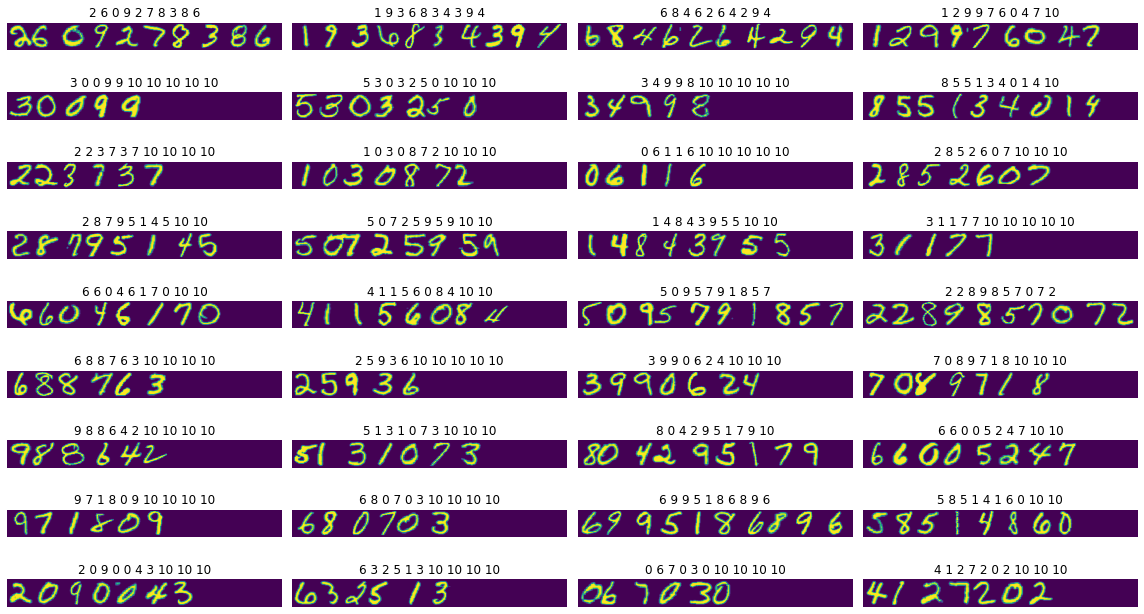

In [5]:
n_images = 36
n_cols = 4
n_rows = n_images // n_cols + 1

fig = plt.figure(n_rows, figsize=(n_cols * 4, n_rows))

for num in range(n_images):
  i = num // n_cols
  j = num % n_cols
  train_img_tensor, labels_tenzor, labels_lens = dataset[i]
  ax = fig.add_subplot(n_rows, n_cols, i  * n_cols + j + 1)
  ax.set_title(' '.join([str(label.item()) for label in labels_tenzor[0] if label.item() != blank_label]))
  ax.imshow(train_img_tensor[0])
  ax.axis('off')
plt.tight_layout()

In [6]:
class RCNN(nn.Module):

  def __init__(self,
               num_classes,
               cnn_input_image_size, 
               cnn_channels_list, 
               cnn_kernel_size=(3, 3), 
               rnn_hidden=256,
               rnn_n_layers=4, 
               rnn_dropout=0.3):
    super().__init__()

    features = []
    image_size = cnn_input_image_size

    for n in range(len(cnn_channels_list)):
      if n % 2:
        features.append(nn.Conv2d(in_channels=cnn_channels_list[n][0],
                                  out_channels=cnn_channels_list[n][1],
                                  kernel_size=cnn_kernel_size, 
                                  stride=2))
      else:
        features.append(nn.Conv2d(in_channels=cnn_channels_list[n][0],
                                  out_channels=cnn_channels_list[n][1],
                                  kernel_size=cnn_kernel_size, 
                                  stride=1))
      features.append(nn.LeakyReLU(0.1))
      features.append(nn.BatchNorm2d(cnn_channels_list[n][1]))
      image_size = ((image_size[0] - cnn_kernel_size[0]) // (1 + int(n % 2)) + 1, 
                    (image_size[1] - cnn_kernel_size[1]) // (1 + int(n % 2)) + 1)
      # print(image_size)

    self.image_features = nn.Sequential(*features)
    
    rnn_input_size = image_size[0] * cnn_channels_list[-1][-1]
    self.rnn_hidden = rnn_hidden
    self.rnn = nn.LSTM(rnn_input_size,
                       rnn_hidden, 
                       num_layers=rnn_n_layers,
                       batch_first=True, 
                       dropout=rnn_dropout,
                       bidirectional=True)
    
    self.fc = nn.Linear(rnn_hidden * 2, num_classes)
  
  def forward(self, image):
    bs = image.shape[0]
    
    cnn_features = self.image_features(image)
    # print(cnn_features.shape)
    
    seq_len = cnn_features.shape[-1]
    cnn_features = cnn_features.permute(0, 3, 2, 1).contiguous()
    rnn_input = cnn_features.view(bs, seq_len, -1)
    
    rnn_output, (rnn_hidden, rnn_cell) = self.rnn(rnn_input)
    
    output = torch.stack([F.log_softmax(self.fc(rnn_output[i]), dim=-1) 
                          for i in range(rnn_output.shape[0])])
    return output

In [7]:
cnn_output_height = 6
cnn_output_width = 69

num_classes = 10 + 1 + 1
input_size = (28, 28)
channels_list = [(1, 32), (32, 32), (32, 64), (64, 64)]

rcnn = RCNN(num_classes,
            input_size, 
            channels_list, 
            cnn_kernel_size=(2, 2), 
            rnn_hidden=256,
            rnn_n_layers=4,
            rnn_dropout=0.3)

dataloader = data.DataLoader(dataset, batch_size=64, shuffle=True)
criterion = nn.CTCLoss(blank=blank_label)
optimizer = opt.Adam(rcnn.parameters(), lr=1e-3)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

rcnn = rcnn.to(device)
criterion = criterion.to(device)

In [8]:
def train_epoch(model, iterator, optimizer, criterion, device):
  correct = 0
  total = 0
  error = 0

  for batch in iterator:
      image, labels, labels_lens = batch
      batch_size = image.shape[0]
      labels = labels.squeeze()
      labels_lens = labels_lens.squeeze()
      
      optimizer.zero_grad()
      y_pred = model(image.to(device))
      y_pred = y_pred.permute(1, 0, 2)
      
      output_width = y_pred.shape[0]
      input_lengths = torch.IntTensor(batch_size).fill_(output_width)

      target_lengths = labels_lens

      loss = criterion(y_pred, labels, input_lengths, target_lengths)
      loss.backward()
      optimizer.step()

      error += loss.item()
      _, max_index = torch.max(y_pred, dim=2)  # max_index.shape == torch.Size([32, 64])
      
      for i in range(batch_size):
          raw_prediction = list(max_index[:, i].detach().cpu().numpy())
          prediction = torch.IntTensor([c for c, _ in itertools.groupby(raw_prediction) if c not in [pad_label, blank_label]])
          curr_label = torch.IntTensor([item.item() for item in labels[i] if item.item() != pad_label])
          if len(prediction) == len(curr_label) and torch.all(prediction.eq(curr_label)):
              correct += 1
          total += 1
  return correct / total, error / len(iterator)

In [9]:
for i in range(5):
  train_accuracy_sequence, error = train_epoch(rcnn, dataloader, optimizer, criterion, device)
  print(i + 1, 'TRAINING. Correct sequence ratio:', train_accuracy_sequence, 'Mean Error:', error)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


1 TRAINING. Correct sequence ratio: 0.0 Mean Error: 2.9177511148392017
2 TRAINING. Correct sequence ratio: 0.2635 Mean Error: 1.2113233340583789
3 TRAINING. Correct sequence ratio: 0.8703 Mean Error: 0.08038759424950287
4 TRAINING. Correct sequence ratio: 0.922 Mean Error: 0.04391040902727159
5 TRAINING. Correct sequence ratio: 0.9368 Mean Error: 0.03466027380103708


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


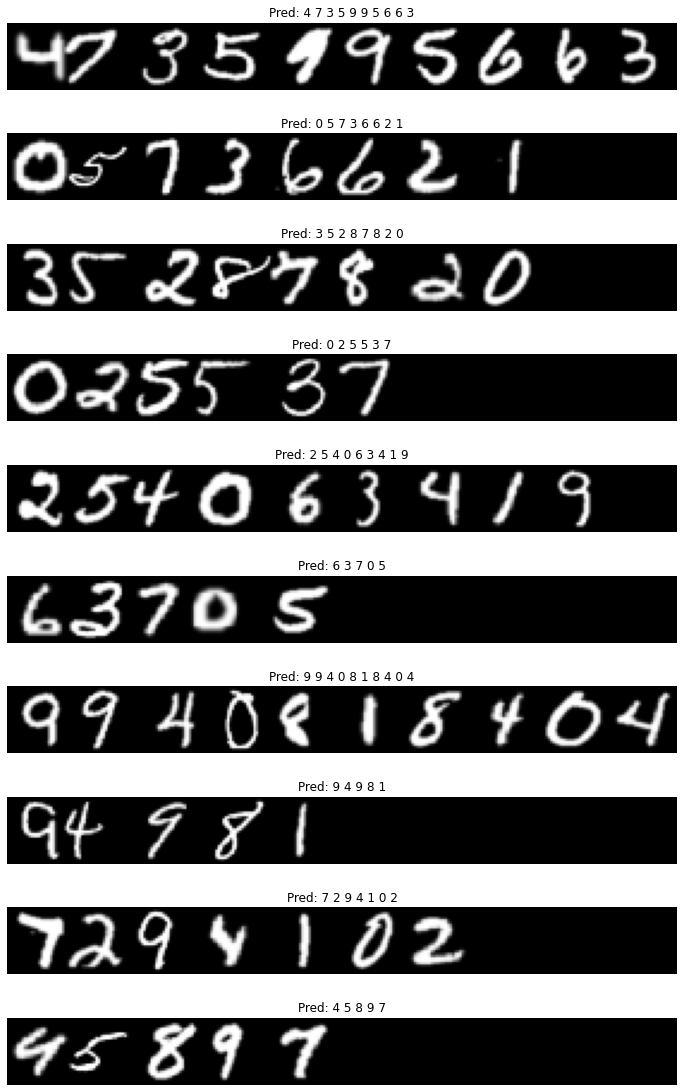

In [10]:
test_preds = []
number_of_test_imgs = 10

dataset_test = EMNISTDataset(train=False, 
                             max_seq_len=10,
                             pad_label=pad_label,
                             blank_label=blank_label)

test_loader = torch.utils.data.DataLoader(dataset_test,
                                          batch_size=number_of_test_imgs, 
                                          shuffle=True)
(test_image, test_labels, test_labels_len) = next(iter(test_loader))

rcnn.eval()
with torch.no_grad():
  y_pred = rcnn(test_image.to(device))
  y_pred = y_pred.permute(1, 0, 2)

_, max_index = torch.max(y_pred, dim=2)
for i in range(test_image.shape[0]):
  raw_prediction = list(max_index[:, i].detach().cpu().numpy())
  prediction = torch.IntTensor([c for c, _ in itertools.groupby(raw_prediction) if c != blank_label])
  test_preds.append(prediction)

fig = plt.figure(number_of_test_imgs, figsize=(12, number_of_test_imgs * 2))

for j in range(number_of_test_imgs):
  ax = fig.add_subplot(number_of_test_imgs, 1, j + 1)
  ax.imshow(test_image[j][0], cmap='gray')
  ax.set_title("Pred: " + " ".join(list(map(str, test_preds[j].numpy()))))
  ax.axis('off')